# Navigation Project

---

[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif "Trained Agent"

This notebook descripts the results of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).
In this project, we train an agent to navigate and collect bananas in a large, square world.  

![Trained Agent][image1]

A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana.  Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.  

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  Given this information, the agent has to learn how to best select actions.  Four discrete actions are available, corresponding to:
- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.

The `README.md` file has information on how to setup the environement.

### Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import merge
from trainer import train
from multiprocessing import Pool

import logging; logging.disable(logging.WARNING)
%matplotlib inline

The baseline configuration for the DQN-based agent.  The sequential architecture is as follows:

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fc1_units | relu
fc1_units | fc2_units | relu
fc1_units | action size | none



Each of the following sections explores different regions of the hyperparameter space.

In [65]:
baseline_config = {
    'eps_start':1.0,     # Starting value for epsilon in epsilon-greedy algorithm
    'eps_end':0.01,      # Ending value for epsilon in epsilon-greedy algorithm
    'eps_decay':0.995,    # Decay rate for epsilon in epsilon-greedy algorithm
    'network_args': {    # Network creation arguments
        'fc1_units': 32, # Size of the first fully connected layer output
        'fc2_units': 32  # Size of the second fully connected layer output
    },
    'gamma':0.99,        # Reward discount rate
    'tau': 1e-3,         # Update step size
    'lr':1e-3,           # Initial learning rate
    'lr_decay':1,        # Learning rate decay factor
    'double_q': False,   # Use DDQN
    'dueling': False,    # Use Dueling DQN
    'ray_layer': False   # Using ray-tracing initial layer architecture
}

#### Effects of $\epsilon$ evolution

In this section, we measure the effect different $\epsilon$-decay rates have on the agent score.

In [5]:
def train_eps_decay(args):
    port, decay = args
    return train(
        merge(baseline_config, {
            'eps_decay':decay
        }),
        n_episodes=1800,
        base_port=port,
        name="decay - {}".format(decay))

with Pool(3) as p:
    eps_decay_scores = p.map(train_eps_decay, zip([5015, 5025, 5035],[0.995,0.99,0.98]))
    
eps_decays = pd.concat(eps_decay_scores, axis=1)

episode: 100%|██████████| 1800/1800 [29:39<00:00,  1.42it/s, avg_score=14.2]


Below we see that a relatively low $\epsilon$-decay rate of 0.98 increases the mean score in the early episodes and does not decrease the mean score (relative to the other set) during later episodes.  

In the following sections, we set the $\epsilon$-decay rate to 0.98.

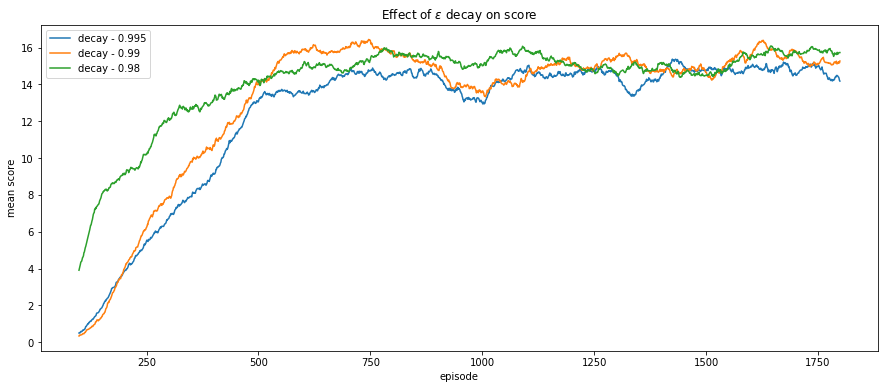

In [45]:
ax = eps_decays.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of $\epsilon$ decay on score");

#### Effects of learning rate evolution

In this section, we measure the effect different learning-rate decay schedules have on the agent score.

In [13]:
def train_lr_decay(args):
    port, decay = args
    return train(
        merge(baseline_config, {
            'eps_decay':0.98,
            'lr_decay':decay
        }),
        n_episodes=1800,
        base_port=port,
        name="decay - {}".format(decay))

with Pool(3) as p:
    lr_decay_scores = p.map(train_lr_decay, zip([5015, 5025, 5035],[0.9995,0.995,0.99]))
    
lr_decays = pd.concat(lr_decay_scores, axis=1)

episode: 100%|██████████| 1800/1800 [29:34<00:00,  1.46it/s, avg_score=16.4]


Below we see that a relatively moderate decay-rate of 0.995 increases the mean score in the middle episodes and does not decrease the mean score (relative to the other set) during later episodes.  In contrast, 0.99 achieved markedly lower scores, while 0.9995 was similar.

In the following sections, we set the learning-rate decay schedule to 0.995.

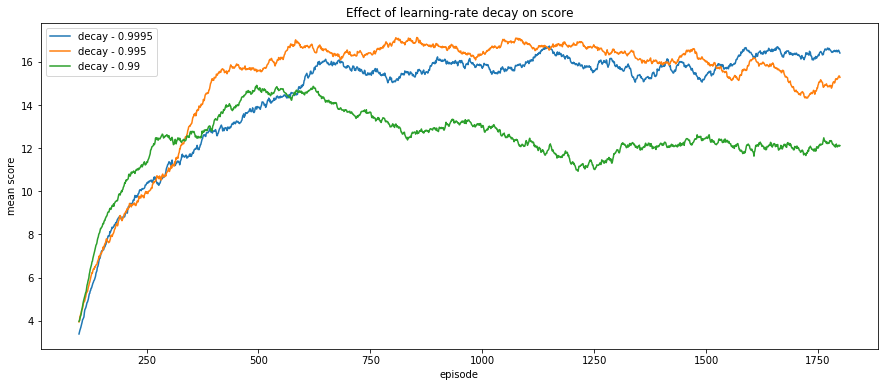

In [46]:
ax = lr_decays.rolling(100).mean().plot(figsize=(15,6))
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of learning-rate decay on score");

#### Effects of $\tau$

In this section, we measure the effect different $\tau$ settings have on the agent score.

In [20]:
def train_tau(args):
    port, tau = args
    return train(
        merge(baseline_config, {
            'eps_decay':0.98,
            'lr_decay':0.995,
            'tau':tau
        }),
        n_episodes=1800,
        base_port=port,
        name="tau - {}".format(tau))

with Pool(3) as p:
    tau_scores = p.map(train_tau, zip([5015, 5025, 5035],[1e-2,1e-3,1e-4]))
    
taus = pd.concat(tau_scores, axis=1)

episode: 100%|██████████| 1800/1800 [29:45<00:00,  1.34it/s, avg_score=15.3]


Below we see that a relatively high setting of 0.01 increases the mean score in the early episodes and does not decrease the mean score (relative to the other set) during later episodes.  In contrast, 0.0001 achieved markedly lower scores, while 0.001 was similar.

In the following sections, we set the learning-rate decay schedule to 0.995.

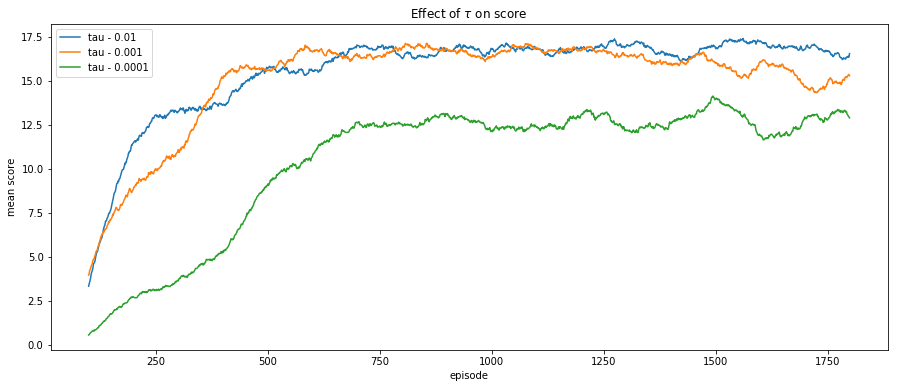

In [55]:
ax = taus.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of $\\tau$ on score");

#### Effects of the layer size

In this section, we measure the effect different layer sizes have on the agent score.

In [22]:
def train_layer_size(args):
    port, layer_size = args
    return train(
        merge(baseline_config, {
            'eps_decay':0.98,
            'lr_decay':0.995,
            'tau':1e-2,
            'network_args': {    
                'fc1_units': layer_size, 
                'fc2_units': layer_size  
            }
        }),
        n_episodes=1800,
        base_port=port,
        name="layer_size - {}".format(layer_size))

with Pool(4) as p:
    layer_size_scores = p.map(train_layer_size, zip([5015, 5025, 5035, 5045],[16, 32, 64, 128]))
    
layer_sizes = pd.concat(layer_size_scores, axis=1)

episode: 100%|██████████| 1800/1800 [42:43<00:00,  1.78it/s, avg_score=16.4]


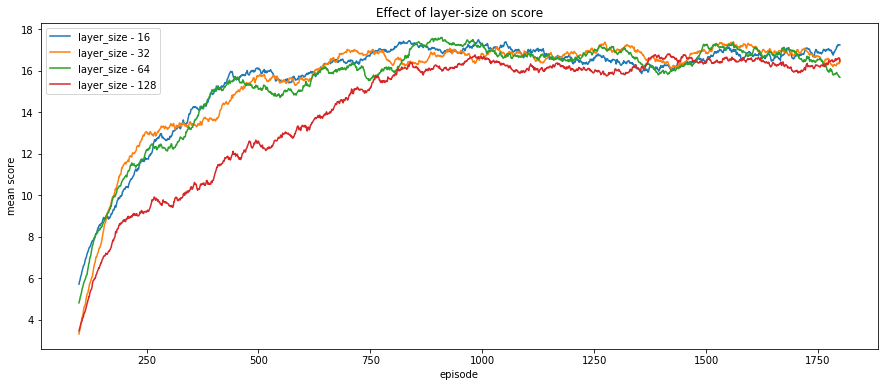

In [57]:
ax=layer_sizes.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of layer-size on score");

#### Effects of Double Q-Learning

In this section, we measure the effect [double DQN](https://arxiv.org/abs/1509.06461) has on the agent score.

In [24]:
def train_double_q(args):
    port, double_q = args
    return train(
        merge(baseline_config, {
            'eps_decay':0.98,
            'lr_decay':0.995,
            'tau':1e-2,
            'network_args': {    
                'fc1_units': 16, 
                'fc2_units': 16  
            },
            'double_q': double_q
        }),
        n_episodes=1800,
        base_port=port,
        name="double_q - {}".format(double_q))

with Pool(2) as p:
    double_q_scores = p.map(train_double_q, zip([5015, 5025],[True, False]))
    
double_qs = pd.concat(double_q_scores, axis=1)

episode: 100%|██████████| 1800/1800 [52:28<00:00,  1.53s/it, avg_score=15.4]


Enabling Double DQN has a detrimental effect on score.

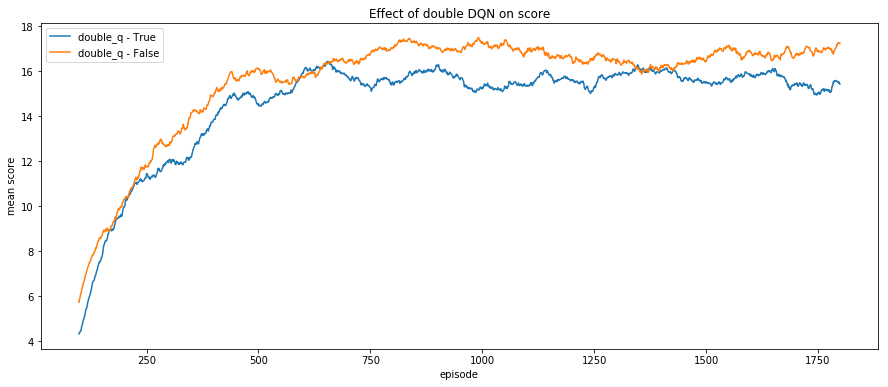

In [67]:
ax = double_qs.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of double DQN on score");

#### Effects of the Dueling DQN

In this section, we measure the effect [dueling DQN](https://arxiv.org/abs/1511.06581) has on the agent score.

The advantage architecture is as follows:

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fc1_units | relu
fc1_units | fc2_units | relu
fc1_units | action size | none

The value architecture is as follows:

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fc1_units | relu
fc1_units | fc2_units | relu
fc1_units | 1 | none

In [26]:
def train_dueling(args):
    port, dueling = args
    return train(
        merge(baseline_config, {
            'eps_decay':0.98,
            'lr_decay':0.995,
            'tau':1e-2,
            'network_args': {    
                'fc1_units': 16, 
                'fc2_units': 16  
            },
            'double_q': False,
            'dueling': dueling
        }),
        n_episodes=1800,
        base_port=port,
        name="dueling - {}".format(dualing))

with Pool(2) as p:
    dualing_scores = p.map(train_dueling, zip([5015, 5025],[True, False]))
    
dualings = pd.concat(dualing_scores, axis=1)

episode: 100%|██████████| 1800/1800 [21:29<00:00,  1.26it/s, avg_score=15.9]


Enabling dueling DQN has a detrimental effect on score.

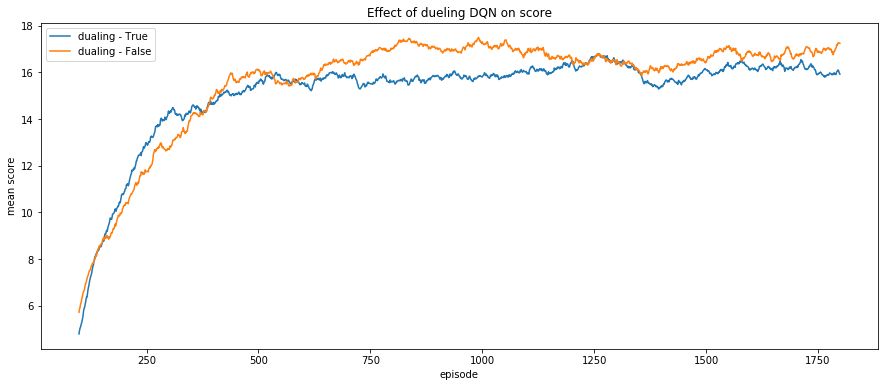

In [66]:
ax = dualings.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of dueling DQN on score");

#### Effects of the ray-tracing layer

In this test, we consider a custom architecture where the first layer of DQN is modified and replayed by the ray-tracing layer.  In this layer, the 37-dimensional input is broken down into seven 5-dimensional ray-trace inputs plus one 2-dimensional velocity input.  Each ray-trace block is passed into the same fully-connected layer.  The outputs are concatenated with the velocity input to provide the input to the second layer.

In [28]:
def train_ray_layer(args):
    port, ray_layer = args
    return train(
        merge(baseline_config, {
            'eps_decay':0.98,
            'lr_decay':0.995,
            'tau':1e-2,
            'network_args': {    
                'fc1_units': 16, 
                'fc2_units': 16  
            },
            'double_q': False,
            'dueling': False,
            'ray_layer': ray_layer
        }),
        n_episodes=1800,
        base_port=port,
        name="ray_layer - {}".format(ray_layer))

with Pool(2) as p:
    ray_layer_scores = p.map(train_ray_layer, zip([5015, 5025],[True, False]))
    
ray_layers = pd.concat(ray_layer_scores, axis=1)

episode: 100%|██████████| 1800/1800 [56:44<00:00,  1.66s/it, avg_score=16.4]


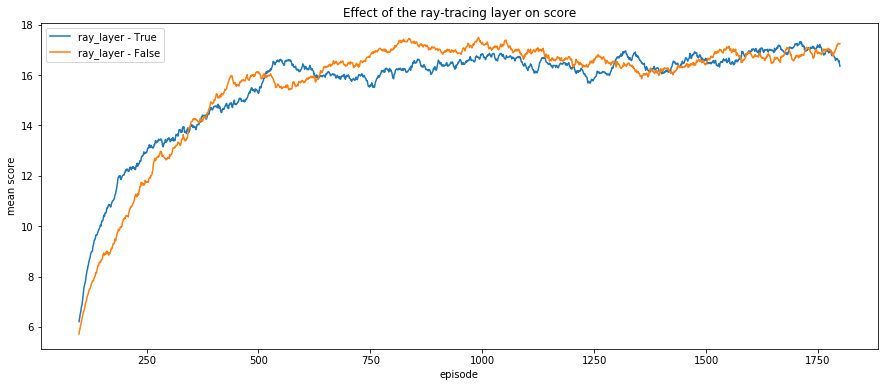

In [64]:
ax = ray_layers.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Effect of the ray-tracing layer on score");

#### Record final settings

In [ ]:
final_scores = train({
    'eps_start':1.0,     # Starting value for epsilon in epsilon-greedy algorithm
    'eps_end':0.01,      # Ending value for epsilon in epsilon-greedy algorithm
    'eps_decay':0.98,    # Decay rate for epsilon in epsilon-greedy algorithm
    'network_args': {    # Network creation arguments
        'fc1_units': 16, # Size of the first fully connected layer output
        'fc2_units': 16  # Size of the second fully connected layer output
    },
    'gamma':0.99,        # Reward discount rate
    'tau': 1e-2,         # Update step size
    'lr':1e-3,           # Initial learning rate
    'lr_decay':0.995,    # Learning rate decay factor
    'double_q': False,   # Use DDQN
    'dueling': False,    # Use Dueling DQN
    'ray_layer': False   # Using ray-tracing initial layer architecture
    },
    n_episodes=1800,
    save_path="./saved-models/dqn-16-16.pth",
    name="final")

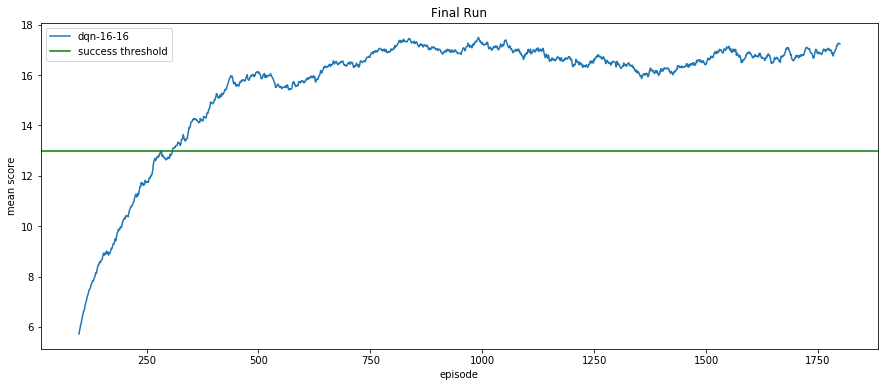

In [85]:
ax = final_scores.rolling(100).mean().plot(figsize=(15,6));
ax.set_xlabel("episode");
ax.set_ylabel("mean score");
ax.set_title("Final Run");
ax.axhline(13, c="g");
ax.legend(['dqn-16-16','success threshold']);

### Closing notes

It was moderately surpising that none of the additional techniques--double DQN, dueling DQN, the ray-tracing layer--seemed to improve over vanilla DQN.  The remaining techniques from Rainbow may provide an additional boost.